In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import seaborn as sn
import matplotlib.pyplot as plt

from tqdm import tqdm

import scipy
from scipy.io import loadmat
from scipy.stats import gaussian_kde

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Input, BatchNormalization

import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector


1.Investigating the dataset.

In [3]:
#Load the dataset
X=loadmat("PaviaU.mat")['paviaU']
Y=loadmat("PaviaU_gt.mat")['paviaU_gt']

X.shape,Y.shape

((610, 340, 103), (610, 340))

In [3]:
print(X), print(Y)

[[[ 647  499  464 ... 3221 3238 3250]
  [ 604  546  527 ... 2442 2464 2528]
  [ 621  746  556 ... 2308 2345 2361]
  ...
  [ 524  525  598 ... 2936 2940 2950]
  [ 528  330   70 ... 2737 2774 2829]
  [ 711  483  423 ... 2562 2539 2488]]

 [[ 705  681  668 ... 2607 2607 2609]
  [ 891  692  453 ... 1581 1561 1522]
  [ 547  511  604 ... 1535 1531 1538]
  ...
  [1149  658  434 ... 3247 3251 3277]
  [ 917 1004  743 ... 2828 2806 2808]
  [1037  849  547 ... 2491 2527 2522]]

 [[1084  875  706 ... 2108 2167 2183]
  [ 335  517  611 ... 1105 1109 1095]
  [1042  683  318 ...  806  791  814]
  ...
  [ 799  693  481 ... 2761 2791 2842]
  [ 226  350  613 ... 2885 2879 2859]
  [ 828  571  479 ... 2799 2809 2806]]

 ...

 [[ 733  617  708 ... 2190 2189 2176]
  [ 785  796  979 ... 1963 1983 1972]
  [ 826  828  928 ... 1905 1939 1965]
  ...
  [ 704  710  689 ... 2401 2385 2349]
  [ 376  305    0 ... 2449 2448 2429]
  [1146  919  707 ... 2504 2541 2523]]

 [[ 785  727  871 ... 2166 2179 2178]
  [ 856  894

(None, None)

In [4]:
#Check if the data contains NaN values
print(np.isnan(X).any())
print(np.isnan(Y).any())

False
False


Dataset description 

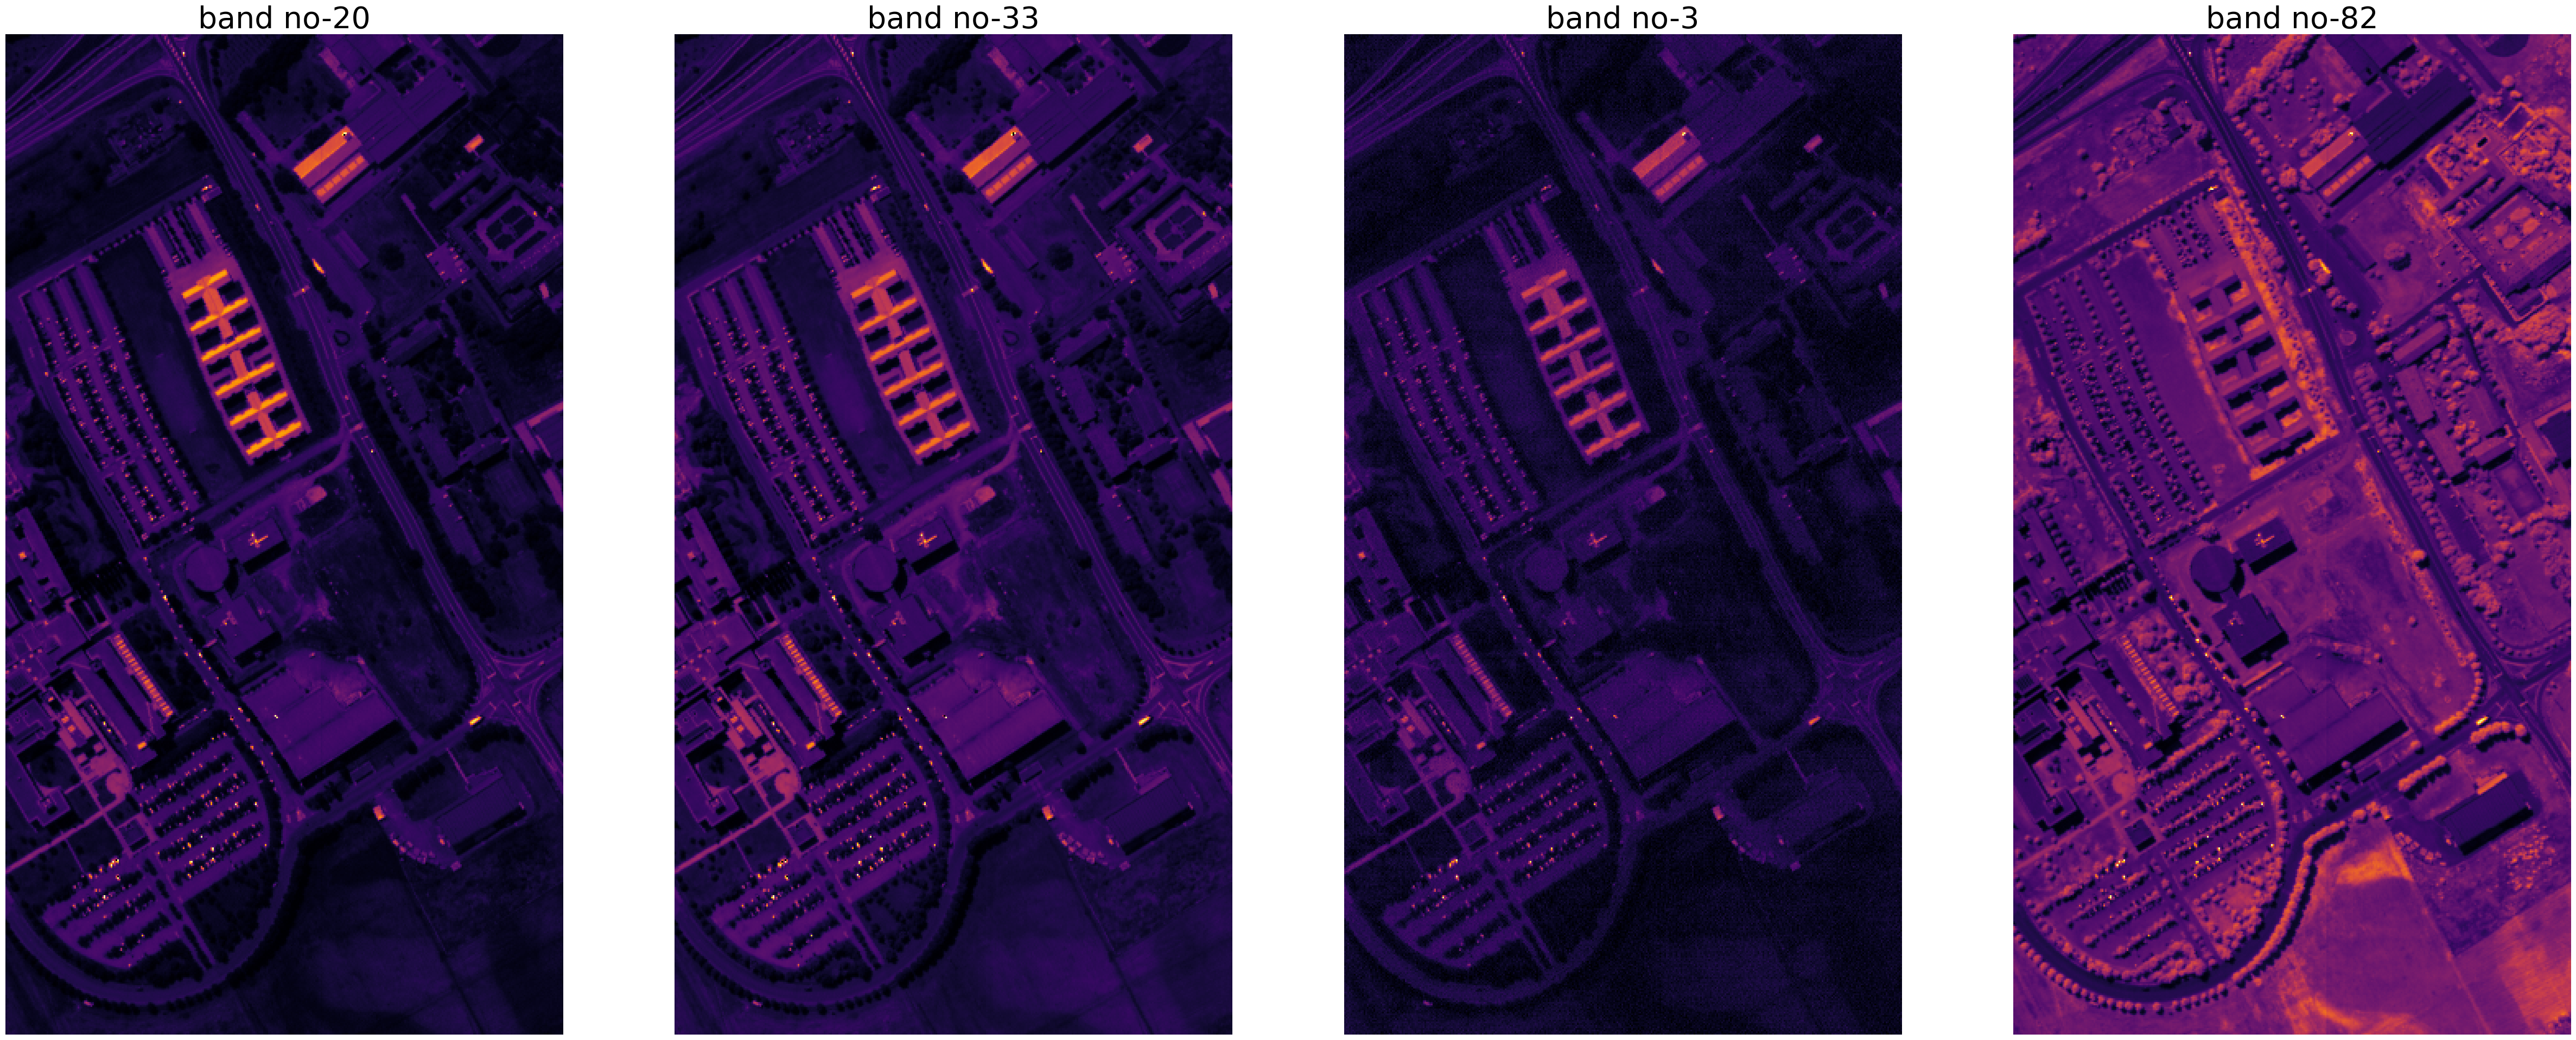

In [7]:
#Visualize randomly selected 4 bands
Xplt=plt.figure(figsize=(61,34))
for i in range(1,5):
    Xplt.add_subplot(1,4,i)
    I=np.random.randint(X.shape[2])
    plt.imshow(X[:,:,I], cmap='inferno')
    plt.axis('off')
    plt.title(f'band no-{I}', fontsize=40)

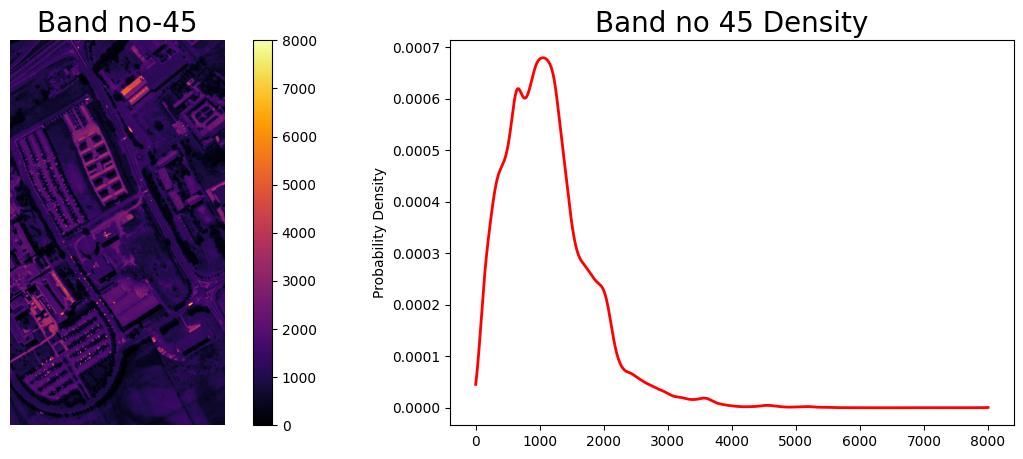

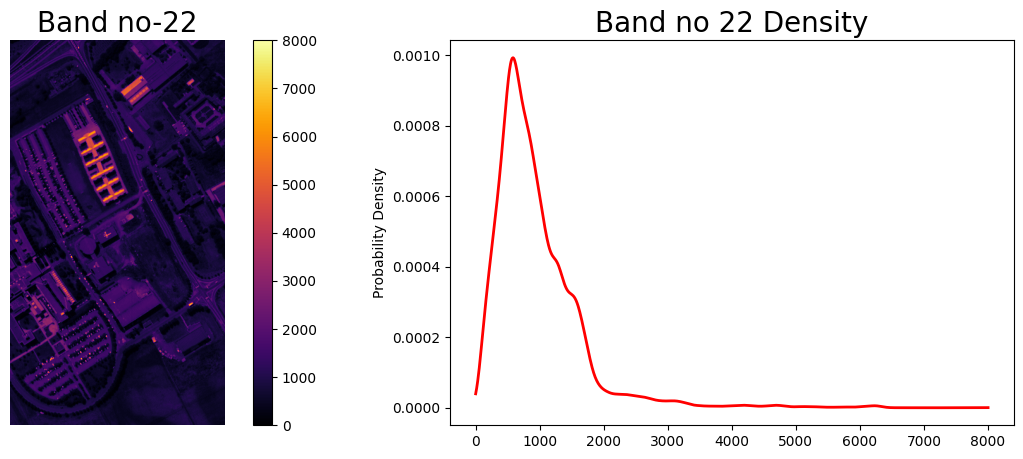

In [6]:
#Visualize randomly selected 2 bands and plot their probability density functions
for i in range(1, 3):
    I = np.random.randint(X.shape[2])
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    # Show X image
    im = axs[0].imshow(X[:, :, I], cmap='inferno')
    axs[0].axis('off')
    axs[0].set_title(f'Band no-{I}', fontsize=20)
    plt.colorbar(im, ax=axs[0])

    # Plot X density
    kde_x = gaussian_kde(X[:, :, I].ravel())
    x_x = np.linspace(np.min(X[:, :, I]), np.max(X[:, :, I]), 1000)
    y_x = kde_x(x_x)
    axs[1].plot(x_x, y_x, 'r-', lw=2)
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Probability Density')
    axs[1].set_title(f'Band no {I} Density', fontsize=20)

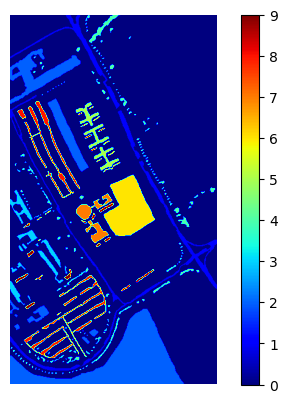

In [7]:
#visualization-PaviaU_gt
plt.imshow(Y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

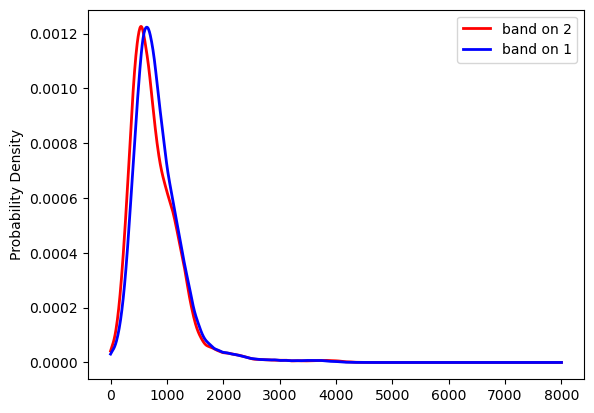

In [8]:
# Visualize the probability density functions (PDFs) for the first and second bands.
z = X[:, :, 2].ravel()
y = X[:, :, 1].ravel()

fig, ax = plt.subplots()

kde_z = gaussian_kde(z)
x_z = np.linspace(np.min(z), np.max(z), 1000)
y_z = kde_z(x_z)
ax.plot(x_z, y_z, 'r-', lw=2, label='band on 2')
kde_y = gaussian_kde(y)
x_y = np.linspace(np.min(y), np.max(y), 1000)
y_y = kde_y(x_y)
ax.plot(x_y, y_y, 'b-', lw=2, label='band on 1')

ax.set_ylabel('Probability Density')
ax.legend()

plt.show()

In [9]:
#Create a function to plot the probability density functions (PDFs) for the specified band and subsequent bands with an interval of 3.
def plot_prob_distribution(X, start_channel):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, j in enumerate(range(start_channel, start_channel + 18, 3)):
        z = X[:, :, j].ravel()
        kde_z = gaussian_kde(z)
        x_z = np.linspace(np.min(z), np.max(z), 1000)
        y_z = kde_z(x_z)
        ax.plot(x_z, y_z, color=colors[i], lw=2, label=f'Band on {j}')
    ax.set_ylabel('Probability Density')
    ax.set_title('Probability Distribution of Spectral Bands')
    ax.legend()
    plt.savefig('prob_distribution.png')
    plt.show()

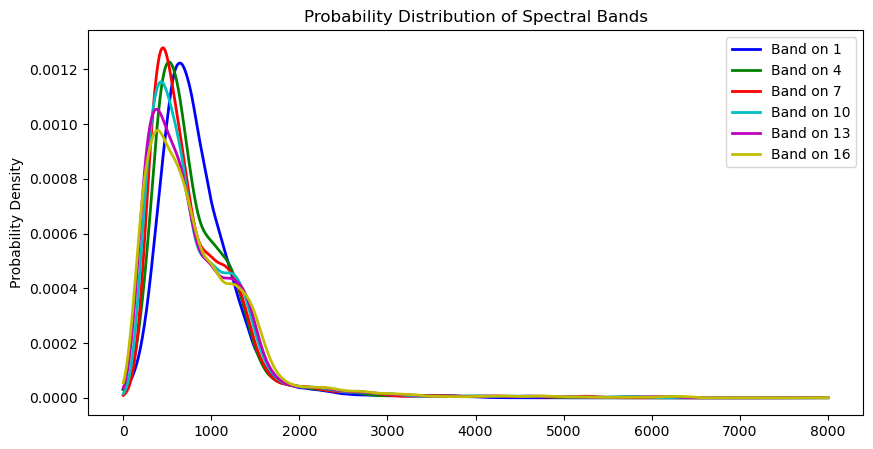

In [10]:
plot_prob_distribution(X, 1)

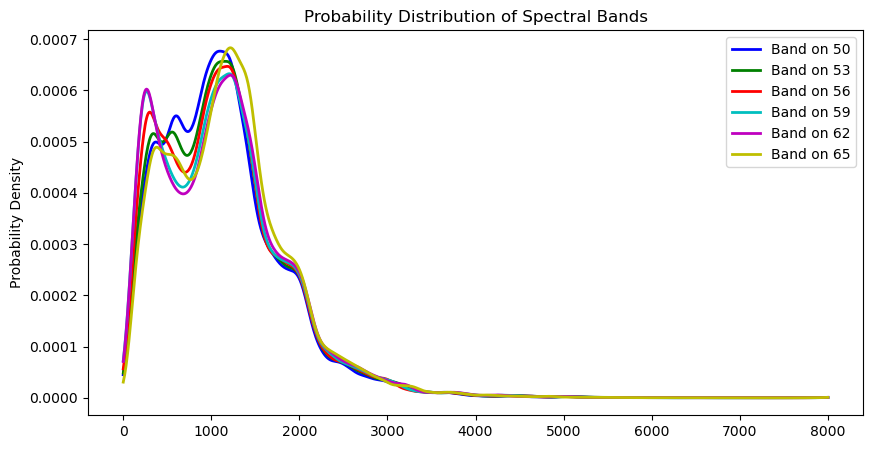

In [11]:
plot_prob_distribution(X, 50)

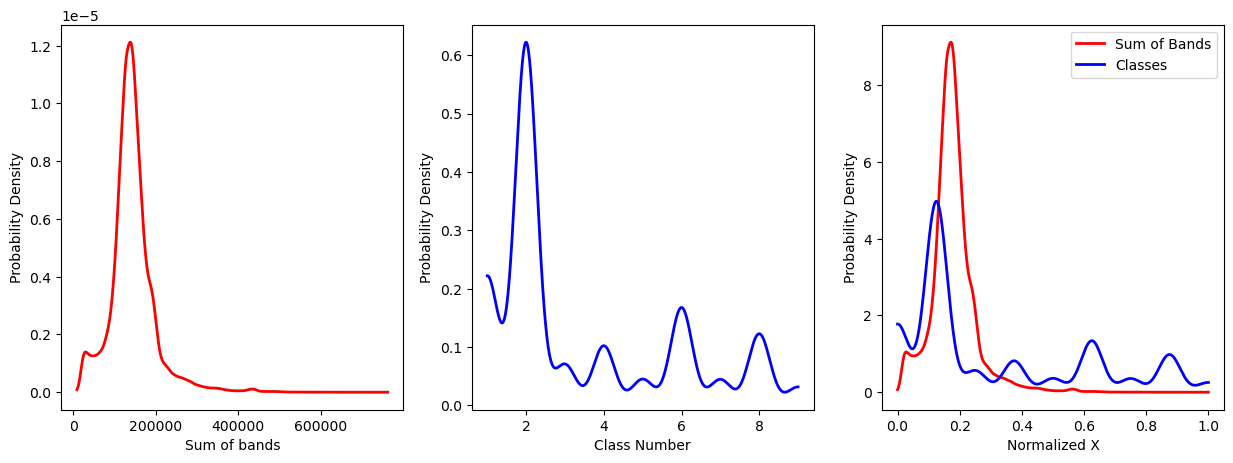

In [12]:
z = z = np.sum(X, axis=2).ravel()
y = Y.ravel()
y = y[y != 0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#Plot the probability density function (PDF) of the sum of all band data.
kde_z = gaussian_kde(z)
x_z = np.linspace(np.min(z), np.max(z), 1000)
y_z = kde_z(x_z)
axs[0].plot(x_z, y_z, 'r-', lw=2)
axs[0].set_xlabel('Sum of bands')
axs[0].set_ylabel('Probability Density')

#Plot the probability density function (PDF) of ground truth classes.
kde_y = gaussian_kde(y)
x_y = np.linspace(np.min(y), np.max(y), 1000)
y_y = kde_y(x_y)
axs[1].plot(x_y, y_y, 'b-', lw=2)
axs[1].set_xlabel('Class Number')
axs[1].set_ylabel('Probability Density')

# Plot densities together
kde_z_norm = gaussian_kde((z - np.min(z)) / (np.max(z) - np.min(z)))
x_z_norm = np.linspace(0, 1, 1000)
y_z_norm = kde_z_norm(x_z_norm)

kde_y_norm = gaussian_kde((y - np.min(y)) / (np.max(y) - np.min(y)))
x_y_norm = np.linspace(0, 1, 1000)
y_y_norm = kde_y_norm(x_y_norm)

axs[2].plot(x_z_norm, y_z_norm, 'r-', lw=2, label='Sum of Bands')
axs[2].plot(x_y_norm, y_y_norm, 'b-', lw=2, label='Classes')
axs[2].set_xlabel('Normalized X')
axs[2].set_ylabel('Probability Density')
axs[2].legend()

plt.show()

Feature selection

In [13]:
#Unfolding the dataset along the X and Y coordinates to reduce dimensionality.
Xr = pd.DataFrame(X.reshape(X.shape[0]*X.shape[1], X.shape[2]))
Xr.columns = pd.RangeIndex(1, len(Xr.columns)+1)    #重新设置列标签使得从1开始
Xr['class'] = Y.ravel()                         #将Y的数据展开并添加到Xr的最后一列
Xr

1    2    3    4    5    6    7    8    9   10  ...    95    96  \
0       647  499  464  371  291  319  365  322  296  305  ...  3416  3335   
1       604  546  527  455  378  377  336  314  324  329  ...  2583  2538   
2       621  746  556  360  285  300  274  276  332  319  ...  2288  2242   
3       637  592  482  556  508  284  178  198  193  224  ...  2675  2609   
4       625  560  480  360  377  341  264  208  231  266  ...  2392  2344   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
207395  574  594  504  411  468  443  378  342  352  434  ...  2150  2157   
207396  485  644  709  582  504  494  434  373  391  421  ...  2264  2295   
207397  593  387  428  461  470  392  331  383  439  355  ...  2393  2407   
207398  593  751  655  458  503  560  482  412  404  454  ...  2340  2333   
207399  889  720  449  402  409  410  424  416  395  319  ...  2496  2502   

          97    98    99   100   101   102   103  class  
0       3256  3226  3205  3210  3221  3238  3250      0  
1       2509  2511  2501  2468  2442  2464  2528      0  
2       2193  2202  2225  2266  2308  2345  2361      0  
3       2541  2551  2571  2569  2573  2620  2644      0  
4       2289  2328  2415  2424  2386  2431  2456      0  
...      ...   ...   ...   ...   ...   ...   ...    ...  
207395  2157  2169  2151  2108  2077  2076  2136      0  
207396  2282  2265  2275  2293  2274  2274  2258      0  
207397  2433  2413  2373  2389  2382  2407  2423      0  
207398  2332  2288  2251  2280  2312  2308  2289      0  
207399  2483  2488  2498  2455  2416  2447  2485      0  

[207400 rows x 104 columns]

In [14]:
#Counting the number of occurrences for each category
val=Xr.groupby('class').size()
val

class
0    164624
1      6631
2     18649
3      2099
4      3064
5      1345
6      5029
7      1330
8      3682
9       947
dtype: int64

In [15]:
#Removing data with class = 0 and reconstructing the dataset.
x= Xr[Xr['class']!=0].iloc[:, :-1].values
yr= Xr[Xr['class']!=0].iloc[:, -1].values
y = to_categorical(yr,  num_classes= np.unique(yr).shape[0]+1, dtype='float32') #one-hot编码

In [16]:
x.shape, y.shape

((42776, 103), (42776, 10))

Feature extraction methods - PCA

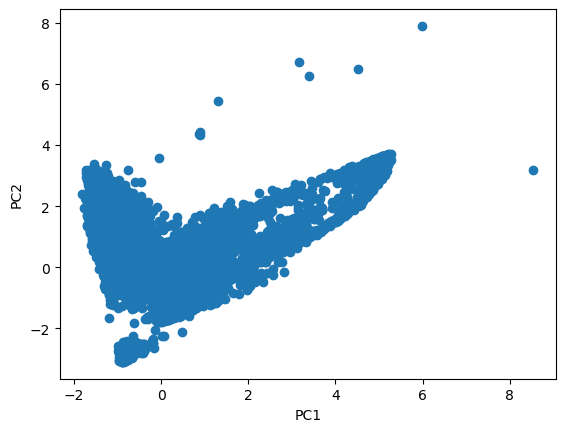

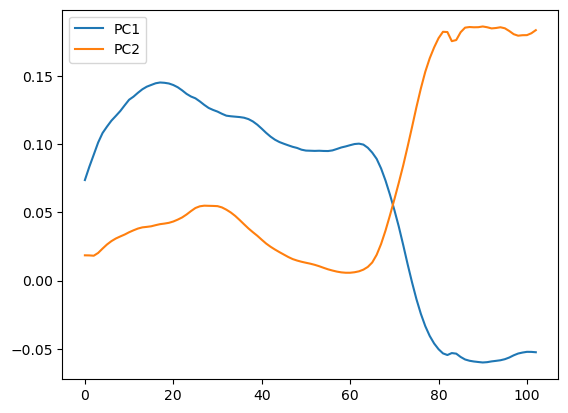

(2, 103)

In [17]:
#  Performing principal component analysis (PCA) on the dataset and retaining only 2 principal components
pca = PCA(n_components=2, whiten=True)
x_pca = pca.fit_transform(x)

x_pca.shape, y.shape

# Plotting a scatter plot of the processed dataset.
plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Obtaining the matrix of all principal components
all_princ_axes = pca.components_

# Drawing the principal component matrix as two line plots.
plt.plot(all_princ_axes[0], label='PC1')
plt.plot(all_princ_axes[1], label='PC2')
plt.legend()
plt.show()
all_princ_axes.shape

In [18]:
#Create a function to perform PCA, with inputs for the number of principal components and the size of the test set.
def pca_transform(test_size, n_components):
    # Splitting the dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify = y)

    # Performing principal component analysis (PCA) on the training set.
    pca = PCA(n_components=n_components, whiten=True)
    x_train_pca = pca.fit_transform(x_train)

    x_test_pca = pca.fit_transform(x_test)

    # Obtaining the matrix of all principal components.
    all_princ_axes = pca.components_

    # Plotting the principal component matrix as N line plots
    for n in range(1, n_components+1):
        plt.plot(all_princ_axes[n-1], label='PC'+str(n))
        plt.legend(loc='upper right')
        plt.xlim(-5, 130)                                          # Adjusting the X-axis to prevent legend from overlapping the target
    plt.show()  
    
    # 计算累计方差贡献率
    var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

    # 绘制累计方差贡献率曲线
    plt.plot(range(1, len(var_ratio_cumsum)+1), var_ratio_cumsum)
    plt.ylim(0.5, 1)                                                # Set the Y-axis range from 0 to 1
    plt.xlabel('Number of principal components')
    plt.ylabel('Cumulative explained variance ratio (%)')
    for i, ratio in enumerate(var_ratio_cumsum):
        if ratio <= 0.995:
            plt.text(i+1, ratio, f'{ratio*100:.1f}%')               # Display the Y-axis coordinate percentage on each point
    plt.show()

    return x_train_pca, x_test_pca, y_train, y_test

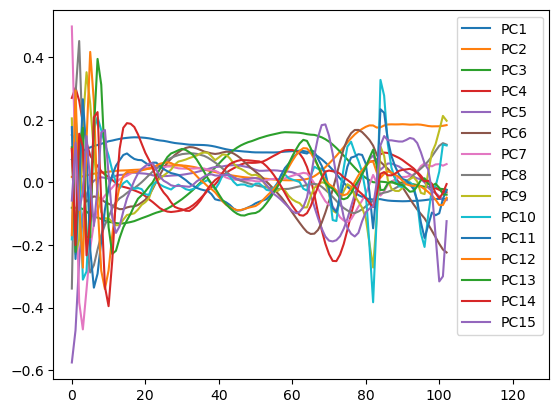

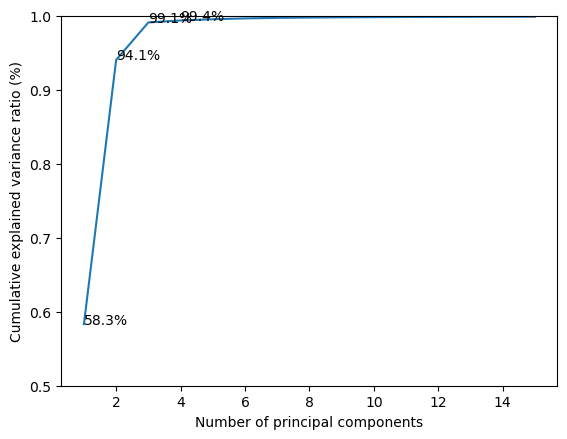

((29943, 15), (12833, 15), (29943, 10), (12833, 10))

In [19]:
#Creating the dataset for subsequent model usage.
x_train_pca, x_test_pca, y_train, y_test = pca_transform(test_size=0.3, n_components=15)
x_train_pca.shape, x_test_pca.shape, y_train.shape, y_test.shape

Model1: PCA + SBS + RF

In [20]:
# Save the features added and their corresponding classification accuracy at each iteration in the 'scores' list
scores = [ ]
for i in tqdm(range(15, 0, -1)):
    sbs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42),
                                    k_features=i,
                                    forward=False,
                                    scoring='accuracy',
                                    cv=5)
    sbs.fit(x_train_pca, y_train)
    selected_features = sbs.k_feature_idx_
    if selected_features is None:
        num_features = 0
    else:
        num_features = len(selected_features)
    
    # Create a new RandomForestClassifier for training and evaluation
    rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
    rf.fit(x_train_pca[:, selected_features], y_train)
    x_test_sbs = x_test_pca[:, selected_features]
    score = rf.score(x_test_sbs, y_test)
    scores.append((num_features, score))

100%|██████████| 15/15 [56:20<00:00, 225.35s/it]


In [21]:
scores

[(15, 0.6043793345281696),
 (14, 0.653627366944596),
 (13, 0.616457570326502),
 (12, 0.7004597522013559),
 (11, 0.6952388373723993),
 (10, 0.7225901971479779),
 (9, 0.7252396166134185),
 (8, 0.6340684173614899),
 (7, 0.7258630094288163),
 (6, 0.7144081664458817),
 (5, 0.7462791241330944),
 (4, 0.7507987220447284),
 (3, 0.7278890360788592),
 (2, 0.715187407465129),
 (1, 0.6118600483129432)]

In [22]:
#Find the optimal number of features and the corresponding accuracy
pd_scores = pd.DataFrame(scores, columns=['num_features', 'score'])
best_feature = pd_scores.loc[pd_scores['score'].idxmax(), 'num_features']
print("best_feature: ", best_feature)
accuracy_M11 = pd_scores.loc[pd_scores['num_features'] == best_feature, 'score'].values[0]
print("Accuracy Found: ", accuracy_M11)

best_feature:  4
Accuracy Found:  0.7507987220447284


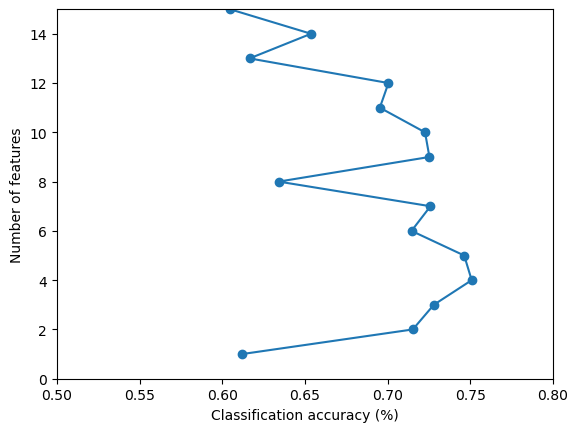

In [23]:
# Plotting the feature selection results
plt.plot([score[1] for score in scores], [score[0] for score in scores], '-o')
plt.xlabel('Classification accuracy (%)')
plt.ylabel('Number of features')
plt.ylim([0, 15])
plt.xlim([0.50, 0.8])
plt.xticks(np.arange(0.50, 0.85, 0.05))
plt.show()

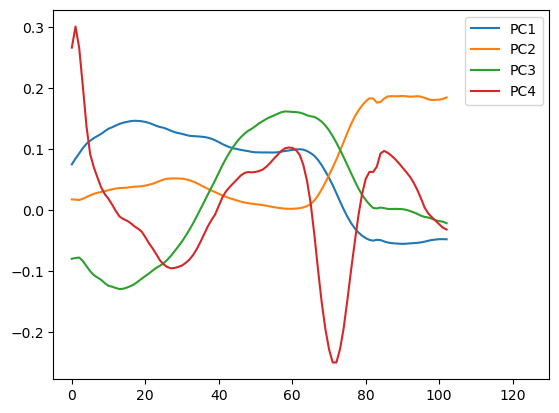

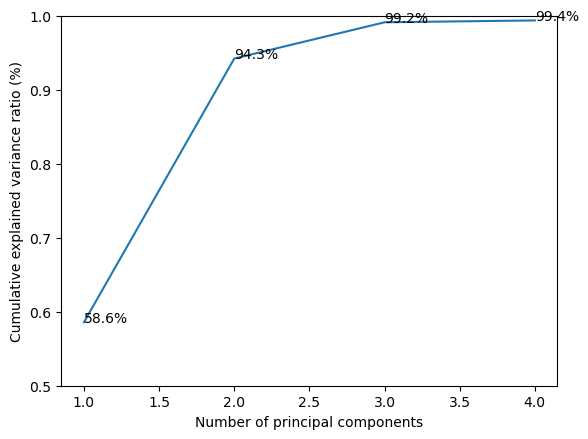

SBS algorithm running time: 36.39 seconds
SBS algorithm classification accuracy: 0.8334169256864037
Random forest classification accuracy: 0.8299696096002493


In [24]:
#Reusing PCA to extract 4 principal components
x_train_SR, x_test_SR, y_train_SR, y_test_SR = pca_transform(test_size=0.3, n_components=4)

start_time = time.time()

# Using the SBS algorithm to select the best feature subset
sbs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
                                k_features=4,
                                forward=False,
                                scoring='accuracy',
                                cv=5)
sbs.fit(x_train_SR, y_train_SR)

end_time = time.time()

# Calculating the algorithm's running time
running_time = end_time - start_time

# Obtaining the selected feature indices after using the SBS algorithm
selected_features = sbs.k_feature_idx_

# Obtaining the number of features after using the SBS algorithm
if selected_features is None:
    num_features = 0
else:
    num_features = len(selected_features)

# Calculating the classification accuracy of the SBS algorithm on the test set
sbs_score = sbs.k_score_

# Creating a new random forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Training the model using the fit method
rf.fit(x_train_SR[:, selected_features], y_train_SR)

# Selecting the test set data with features extracted by the SBS algorithm
x_test_sbs = x_test_SR[:, selected_features]

# alculating the classification accuracy of the model on the test set using the score method, saved in the variable 'rf_score'
rf_score = rf.score(x_test_sbs, y_test_SR)

# Outputting the running time and accuracy of the algorithm
print(f"SBS algorithm running time: {running_time:.2f} seconds")
print(f"SBS algorithm classification accuracy: {sbs_score}")
print(f"Random forest classification accuracy: {rf_score}")


In [25]:
#Extracting predicted values from one-hot encoding
y_pred_SR = np.argmax(rf.predict(x_test_SR),axis=1)
y_test_oh = np.argmax(y_test_SR, 1)

accuracy_M12 = accuracy_score(y_test_oh, y_pred_SR)

# Evaluating the model and obtaining the confusion matrix and classification report
print("\nConfusion Matrix:\n ",confusion_matrix(y_test_oh, y_pred_SR))
print("\nCLASSIFICATION REPORT:\n ",classification_report(y_test_oh, y_pred_SR))


Confusion Matrix:
  [[   0    0    0    0    0    0    0    0    0    0]
 [  94 1760    9   26    0    0   11   61   27    1]
 [  15    0 5424    0   82    0   73    0    1    0]
 [ 125   55    2  313    0    0    0    0  135    0]
 [   3    0   96    0  820    0    0    0    0    0]
 [   3    0    0    0    0  399    1    0    0    0]
 [  45    0  883    0    1    0  576    0    4    0]
 [  22  112    0    2    0    0    0  263    0    0]
 [ 167   23    1   94    0    0    8    0  812    0]
 [   0    0    0    0    0    0    0    0    0  284]]

CLASSIFICATION REPORT:
                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.90      0.88      0.89      1989
           2       0.85      0.97      0.90      5595
           3       0.72      0.50      0.59       630
           4       0.91      0.89      0.90       919
           5       1.00      0.99      1.00       403
           6       0.86      0.38      0.53

C:\Users\86151\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\86151\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\86151\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model_2: PCA + CNN

In [26]:
# Create CNN model
model = Sequential(name='Pavia_University_150')

#Input layer
model.add(Input(shape = x_train_pca[0].shape, name = 'Input_Layer'))

# Normalization layer
model.add(BatchNormalization())

#Fully connected layers
model.add(Dense(128, activation= 'relu'))
model.add(Dense(256, activation= 'relu'))
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))

#Pooling layer
model.add(Flatten())

#Fully connected layers
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))

#Output layer
model.add(Dense(y_train.shape[1], activation= 'softmax'))


# Compile
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])

CNN_Model_150 = model.fit(x = x_train_pca,
                     y = y_train,
                     validation_data = (x_test_pca, y_test),
                     epochs = 150)

Epoch 1/150
936/936 [==============================] - 6s 5ms/step - loss: 1.4287 - accuracy: 0.5407 - val_loss: 0.7414 - val_accuracy: 0.7489
Epoch 2/150
936/936 [==============================] - 5s 5ms/step - loss: 0.4839 - accuracy: 0.8193 - val_loss: 0.6389 - val_accuracy: 0.7750
Epoch 3/150
936/936 [==============================] - 5s 6ms/step - loss: 0.3378 - accuracy: 0.8719 - val_loss: 0.5846 - val_accuracy: 0.8050
Epoch 4/150
936/936 [==============================] - 5s 5ms/step - loss: 0.2887 - accuracy: 0.8882 - val_loss: 0.6303 - val_accuracy: 0.7847
Epoch 5/150
936/936 [==============================] - 5s 5ms/step - loss: 0.2611 - accuracy: 0.9004 - val_loss: 0.5649 - val_accuracy: 0.8019
Epoch 6/150
936/936 [==============================] - 5s 6ms/step - loss: 0.2496 - accuracy: 0.9057 - val_loss: 0.5710 - val_accuracy: 0.8110
Epoch 7/150
936/936 [==============================] - 5s 5ms/step - loss: 0.2385 - accuracy: 0.9079 - val_loss: 0.5897 - val_accuracy: 0.8073

Epoch 58/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1683 - accuracy: 0.9320 - val_loss: 0.6438 - val_accuracy: 0.8137
Epoch 59/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1672 - accuracy: 0.9330 - val_loss: 0.6345 - val_accuracy: 0.8073
Epoch 60/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1684 - accuracy: 0.9338 - val_loss: 0.6398 - val_accuracy: 0.8112
Epoch 61/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1713 - accuracy: 0.9313 - val_loss: 0.6557 - val_accuracy: 0.8043
Epoch 62/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1651 - accuracy: 0.9343 - val_loss: 0.6608 - val_accuracy: 0.7951
Epoch 63/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1675 - accuracy: 0.9335 - val_loss: 0.6314 - val_accuracy: 0.8135
Epoch 64/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1678 - accuracy: 0.9343 - val_loss: 0.6354 - val_accuracy:

Epoch 115/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1519 - accuracy: 0.9394 - val_loss: 0.7412 - val_accuracy: 0.7905
Epoch 116/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1494 - accuracy: 0.9398 - val_loss: 0.6879 - val_accuracy: 0.7992
Epoch 117/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1448 - accuracy: 0.9417 - val_loss: 0.7235 - val_accuracy: 0.7900
Epoch 118/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1540 - accuracy: 0.9386 - val_loss: 0.6922 - val_accuracy: 0.8050
Epoch 119/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1414 - accuracy: 0.9427 - val_loss: 0.7259 - val_accuracy: 0.8026
Epoch 120/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1496 - accuracy: 0.9402 - val_loss: 0.7081 - val_accuracy: 0.8005
Epoch 121/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1477 - accuracy: 0.9425 - val_loss: 0.6526 - val_ac

In [27]:
#Extracting predicted data from one-hot encoding
y_pred_150 = np.argmax(model.predict(x_test_pca), axis=1)

#Convert one hot label to integers
y_test_150=[np.where(r!=0)[0][0] for r in y_test]

402/402 [==============================] - 1s 2ms/step


Model: "Pavia_University_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 15)                60        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                              

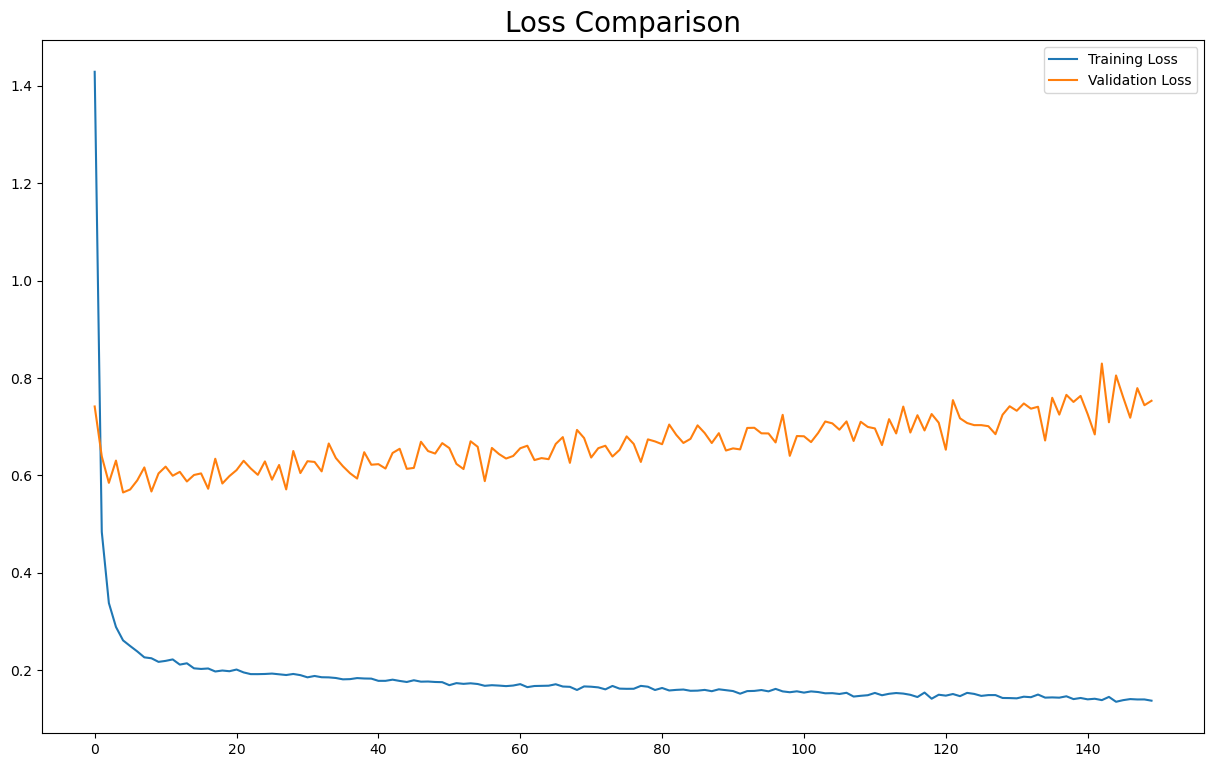

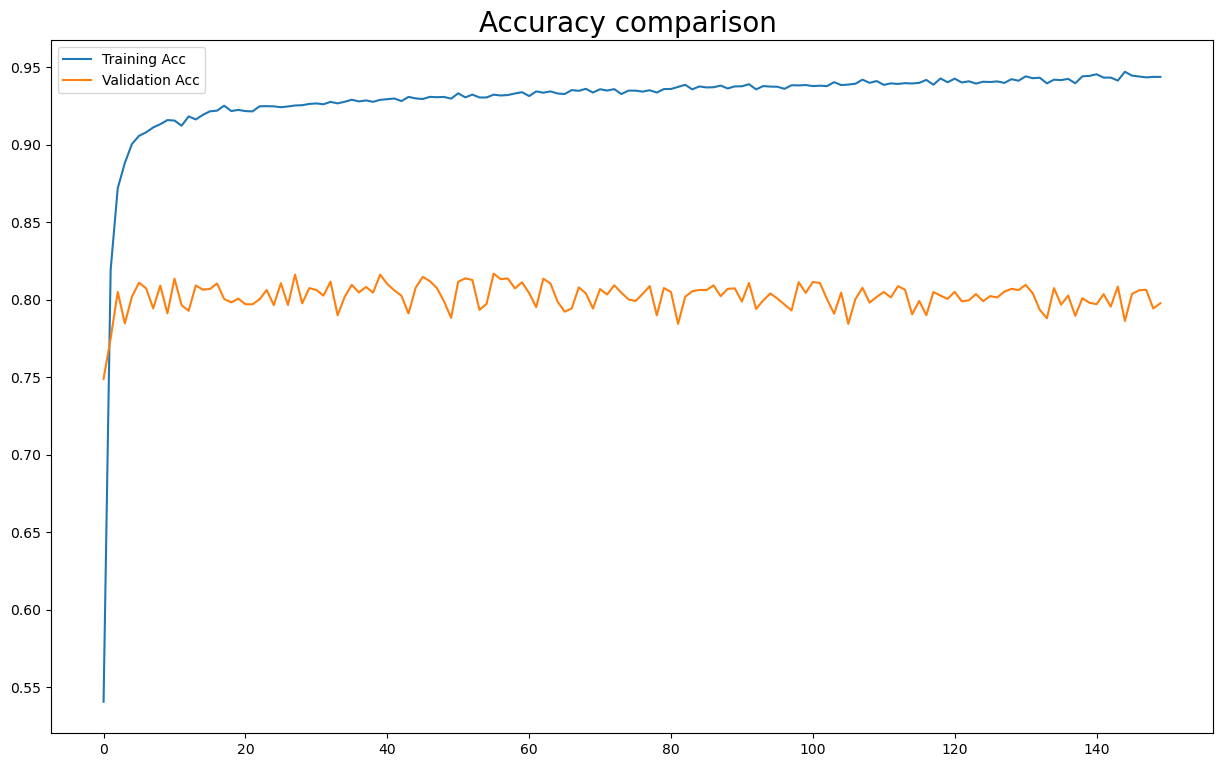

In [28]:
# Model evaluation
model.summary()

#Plotting the loss graph
plt.figure(figsize=(15,9))
plt.title('Loss Comparison',fontsize=20)
plt.plot(CNN_Model_150.history['loss'],)
plt.plot(CNN_Model_150.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()

#Plotting the accuracy graph
plt.figure(figsize=(15,9))
plt.title('Accuracy comparison ',fontsize=20)
plt.plot(CNN_Model_150.history['accuracy'],)
plt.plot(CNN_Model_150.history['val_accuracy'])
plt.legend(['Training Acc','Validation Acc'])
plt.show()

In [29]:
# Calculate model accuracy and obtain the confusion matrix
accuracy_M21 = accuracy_score(y_test_150,y_pred_150)
print("Accuracy Found: ", accuracy_M21)
print("\nConfusion Matrix:\n\n",confusion_matrix(y_pred_150, y_test_150))

Accuracy Found:  0.7977090314034131

Confusion Matrix:

 [[1746    4   34    2    0   21  321   77    1]
 [  10 4819    6  198    0  381    0    7    0]
 [  68    5  362    4    0   12    3  154    0]
 [   1   98    0  701    3    4    0    0    0]
 [   2    1    0    2  398    0    0    0    0]
 [  58  657    1   12    2 1055    4   63    0]
 [  57    0    0    0    0    0   69    0    0]
 [  46   11  227    0    0   36    2  804    0]
 [   1    0    0    0    0    0    0    0  283]]


In [30]:
model2 = Sequential(name='Pavia_University_50')

model2.add(Input(shape=x_train_pca[0].shape, name='Input_Layer'))

model2.add(BatchNormalization())

#Reduced size of fully connected layers
model2.add(Dense(64, activation='relu'))
model2.add(Dense(128, activation='relu'))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dense(y_train.shape[1], activation='softmax'))

model2.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# Reduced number of training epochs
CNN_Model_50 = model2.fit(x=x_train_pca, y=y_train, validation_data=(x_test_pca, y_test), epochs=50)

Epoch 1/50
936/936 [==============================] - 2s 2ms/step - loss: 1.0672 - accuracy: 0.6532 - val_loss: 0.6478 - val_accuracy: 0.7661
Epoch 2/50
936/936 [==============================] - 1s 1ms/step - loss: 0.4389 - accuracy: 0.8421 - val_loss: 0.5568 - val_accuracy: 0.7917
Epoch 3/50
936/936 [==============================] - 1s 1ms/step - loss: 0.3428 - accuracy: 0.8725 - val_loss: 0.5436 - val_accuracy: 0.7951
Epoch 4/50
936/936 [==============================] - 1s 1ms/step - loss: 0.3046 - accuracy: 0.8853 - val_loss: 0.5509 - val_accuracy: 0.7988
Epoch 5/50
936/936 [==============================] - 1s 1ms/step - loss: 0.2809 - accuracy: 0.8947 - val_loss: 0.5362 - val_accuracy: 0.8074
Epoch 6/50
936/936 [==============================] - 1s 1ms/step - loss: 0.2622 - accuracy: 0.9005 - val_loss: 0.5601 - val_accuracy: 0.8000
Epoch 7/50
936/936 [==============================] - 1s 1ms/step - loss: 0.2603 - accuracy: 0.9005 - val_loss: 0.5564 - val_accuracy: 0.8043
Epoch 

In [31]:
y_pred_50 = np.argmax(model2.predict(x_test_pca), axis=1)
y_test_50=[np.where(r!=0)[0][0] for r in y_test]

402/402 [==============================] - 0s 668us/step


Model: "Pavia_University_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 15)                60        
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 64)                1024      
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               66048     
                                                                 
 dense_11 (Dense)            (None, 10)                5130      
                                               

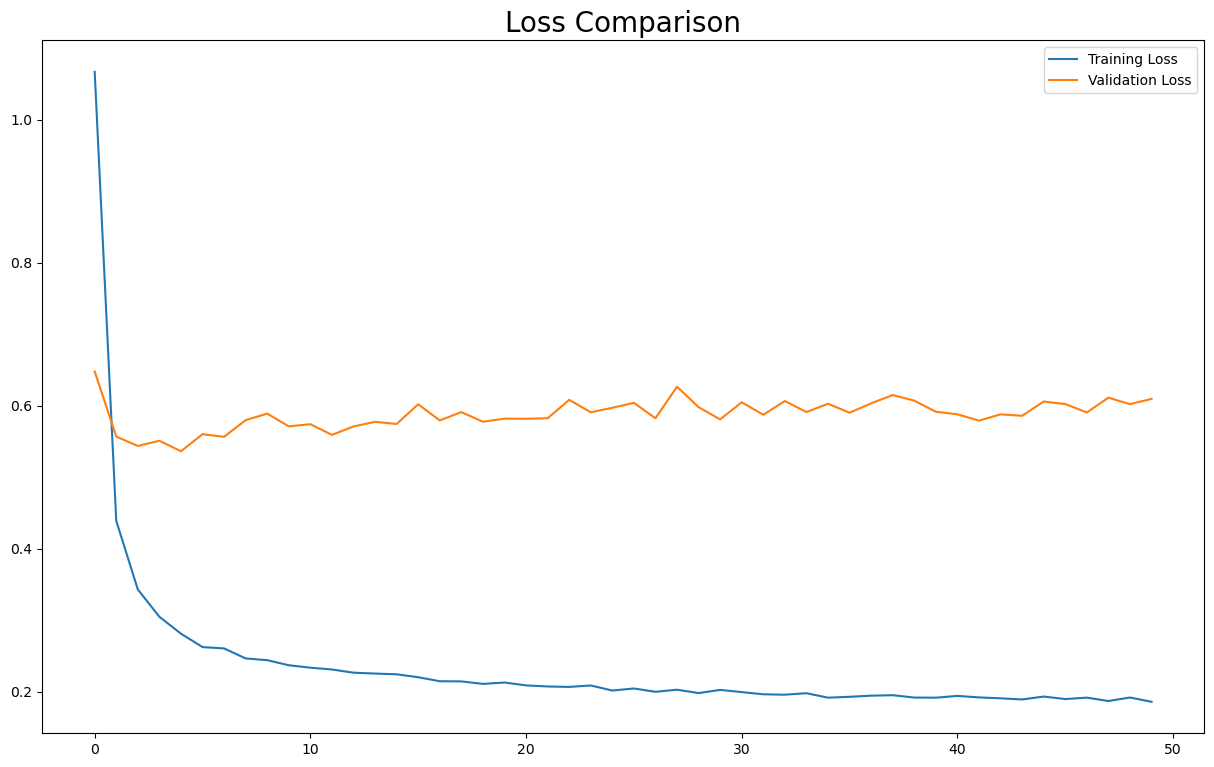

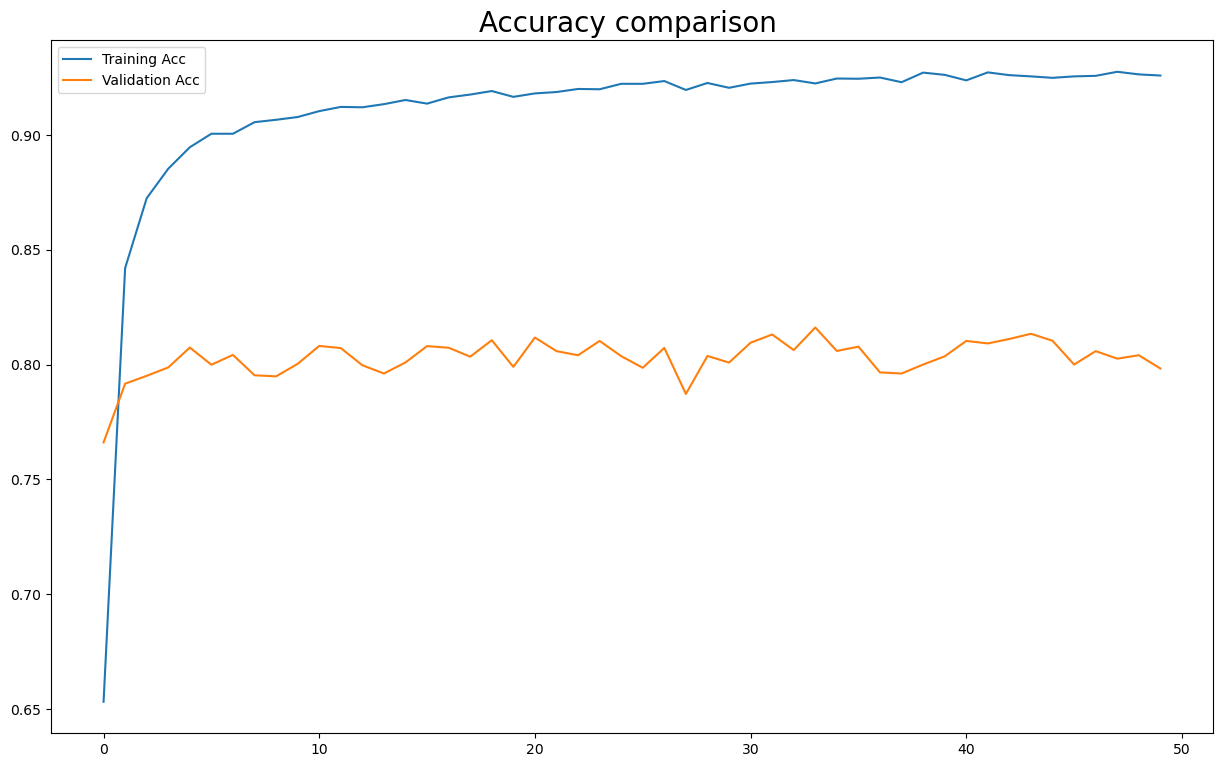

In [32]:
model2.summary()

plt.figure(figsize=(15,9))
plt.title('Loss Comparison',fontsize=20)
plt.plot(CNN_Model_50.history['loss'],)
plt.plot(CNN_Model_50.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()


plt.figure(figsize=(15,9))
plt.title('Accuracy comparison ',fontsize=20)
plt.plot(CNN_Model_50.history['accuracy'],)
plt.plot(CNN_Model_50.history['val_accuracy'])
plt.legend(['Training Acc','Validation Acc'])
plt.show()

In [33]:
accuracy_M22 = accuracy_score(y_test_50,y_pred_50)
print("Accuracy Found: ",accuracy_M22)
print("\nConfusion Matrix:\n\n",confusion_matrix(y_pred_50, y_test_50))

Accuracy Found:  0.7983324242188109

Confusion Matrix:

 [[1772    5   50    1    0   16  295   80    0]
 [   5 4718    5  119    3  370    0    9    0]
 [  33    0  224    0    1    3    1   62    0]
 [   0  172    0  792    3    8    0    0    0]
 [   0    1    0    0  394    2    0    0    1]
 [  40  694    2    7    2 1061    1   53    0]
 [  90    0    1    0    0    0  102    2    0]
 [  49    5  348    0    0   49    0  899    0]
 [   0    0    0    0    0    0    0    0  283]]


Model2.3: Only CNN

In [34]:
x_train_cnn, x_test_cnn,y_train_cnn,y_test_cnn = train_test_split(x,y,test_size=0.30,stratify = y)

In [35]:
model3 = Sequential(name='Pavia_University_C150')

model3.add(Input(shape = x_train_cnn[0].shape, name = 'Input_Layer'))

model3.add(BatchNormalization())

model3.add(Dense(128, activation= 'relu'))
model3.add(Dense(256, activation= 'relu'))
model3.add(Dense(128, activation= 'relu'))
model3.add(Dense(64, activation= 'relu'))

model3.add(Flatten())

model3.add(Dense(1024,activation='relu'))
model3.add(Dense(512,activation='relu'))
model3.add(Dense(256,activation='relu'))

model3.add(Dense(y_train_cnn.shape[1], activation= 'softmax'))


# Compile
model3.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])

CNN_Model_C150 = model3.fit(x = x_train_cnn, 
                     y = y_train_cnn,
                     validation_data = (x_test_cnn, y_test_cnn), 
                     epochs = 150)

Epoch 1/150
936/936 [==============================] - 6s 6ms/step - loss: 0.9302 - accuracy: 0.6844 - val_loss: 0.5486 - val_accuracy: 0.7829
Epoch 2/150
936/936 [==============================] - 5s 6ms/step - loss: 0.6036 - accuracy: 0.7553 - val_loss: 0.4972 - val_accuracy: 0.7914
Epoch 3/150
936/936 [==============================] - 5s 6ms/step - loss: 0.5370 - accuracy: 0.7790 - val_loss: 0.4297 - val_accuracy: 0.8260
Epoch 4/150
936/936 [==============================] - 5s 6ms/step - loss: 0.4998 - accuracy: 0.7999 - val_loss: 0.4033 - val_accuracy: 0.8286
Epoch 5/150
936/936 [==============================] - 5s 5ms/step - loss: 0.4542 - accuracy: 0.8170 - val_loss: 0.3522 - val_accuracy: 0.8648
Epoch 6/150
936/936 [==============================] - 5s 6ms/step - loss: 0.4217 - accuracy: 0.8294 - val_loss: 0.3532 - val_accuracy: 0.8596
Epoch 7/150
936/936 [==============================] - 5s 6ms/step - loss: 0.3943 - accuracy: 0.8391 - val_loss: 0.2770 - val_accuracy: 0.9010

Epoch 58/150
936/936 [==============================] - 5s 6ms/step - loss: 0.2026 - accuracy: 0.9200 - val_loss: 0.1338 - val_accuracy: 0.9518
Epoch 59/150
936/936 [==============================] - 5s 6ms/step - loss: 0.2025 - accuracy: 0.9202 - val_loss: 0.1567 - val_accuracy: 0.9404
Epoch 60/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1979 - accuracy: 0.9219 - val_loss: 0.1647 - val_accuracy: 0.9302
Epoch 61/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1942 - accuracy: 0.9231 - val_loss: 0.2078 - val_accuracy: 0.9149
Epoch 62/150
936/936 [==============================] - 5s 6ms/step - loss: 0.2009 - accuracy: 0.9214 - val_loss: 0.1482 - val_accuracy: 0.9423
Epoch 63/150
936/936 [==============================] - 5s 5ms/step - loss: 0.2021 - accuracy: 0.9202 - val_loss: 0.1464 - val_accuracy: 0.9444
Epoch 64/150
936/936 [==============================] - 5s 6ms/step - loss: 0.2017 - accuracy: 0.9208 - val_loss: 0.1302 - val_accuracy:

Epoch 115/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1781 - accuracy: 0.9297 - val_loss: 0.1915 - val_accuracy: 0.9236
Epoch 116/150
936/936 [==============================] - 5s 5ms/step - loss: 0.1750 - accuracy: 0.9323 - val_loss: 0.1270 - val_accuracy: 0.9524
Epoch 117/150
936/936 [==============================] - 5s 5ms/step - loss: 0.1822 - accuracy: 0.9277 - val_loss: 0.1458 - val_accuracy: 0.9440
Epoch 118/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1815 - accuracy: 0.9279 - val_loss: 0.1324 - val_accuracy: 0.9481
Epoch 119/150
936/936 [==============================] - 5s 5ms/step - loss: 0.1795 - accuracy: 0.9284 - val_loss: 0.1327 - val_accuracy: 0.9495
Epoch 120/150
936/936 [==============================] - 5s 5ms/step - loss: 0.1754 - accuracy: 0.9303 - val_loss: 0.1265 - val_accuracy: 0.9522
Epoch 121/150
936/936 [==============================] - 5s 6ms/step - loss: 0.1806 - accuracy: 0.9304 - val_loss: 0.1371 - val_ac

In [36]:
y_pred_cnn = np.argmax(model3.predict(x_test_cnn), axis=1)

y_test_cnn=[np.where(r!=0)[0][0] for r in y_test_cnn]  #convert one hot label to integers

402/402 [==============================] - 1s 2ms/step


Model: "Pavia_University_C150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 103)               412       
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 128)               13312     
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                             

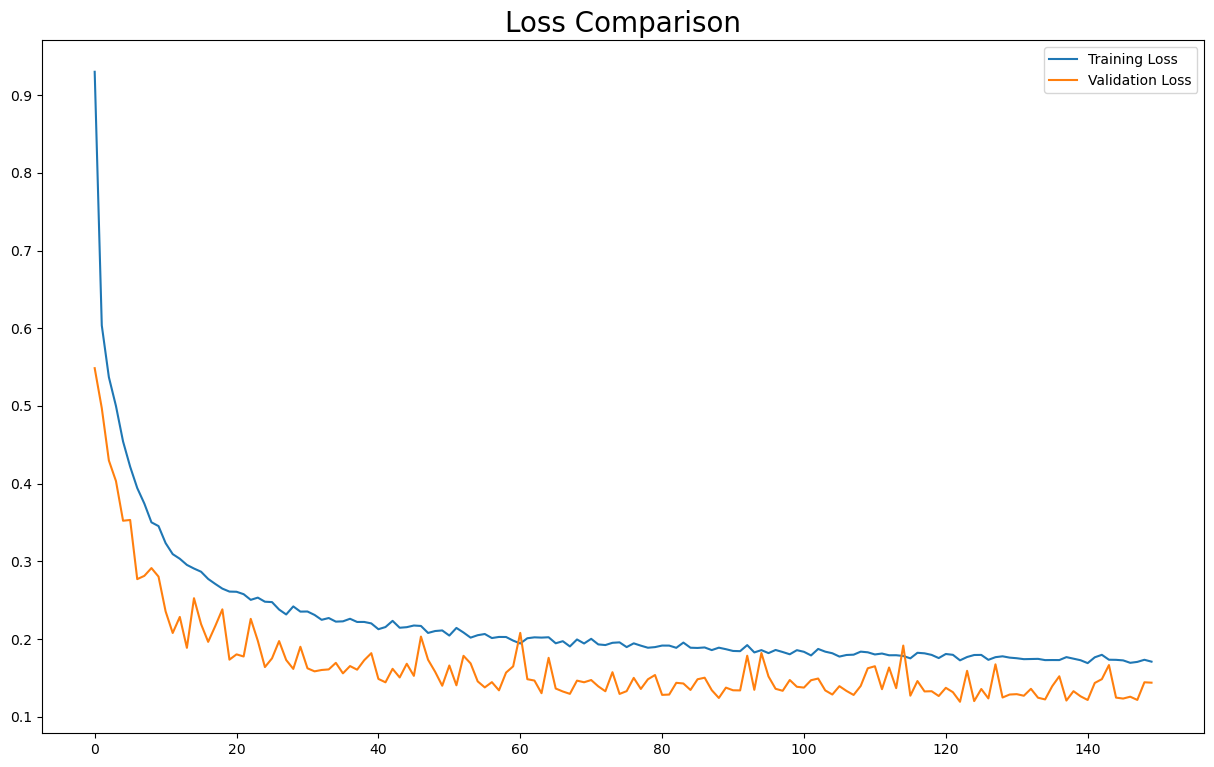

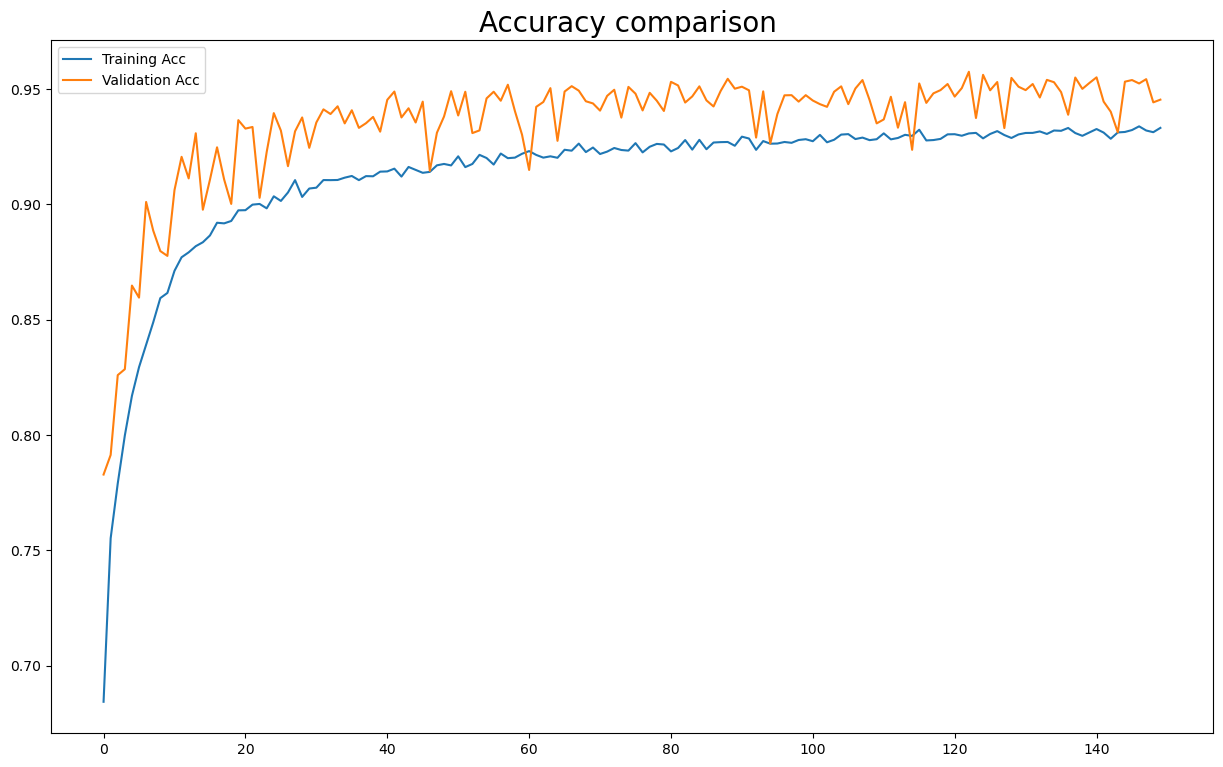

In [37]:
model3.summary()

plt.figure(figsize=(15,9))
plt.title('Loss Comparison',fontsize=20)
plt.plot(CNN_Model_C150.history['loss'],)
plt.plot(CNN_Model_C150.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.show()


plt.figure(figsize=(15,9))
plt.title('Accuracy comparison ',fontsize=20)
plt.plot(CNN_Model_C150.history['accuracy'],)
plt.plot(CNN_Model_C150.history['val_accuracy'])
plt.legend(['Training Acc','Validation Acc'])
plt.show()

In [38]:
#Calculate model accuracy and obtain the confusion matrix
accuracy_M23 = accuracy_score(y_test_cnn,y_pred_cnn)
print("Accuracy Found: ", accuracy_M23)
print("\nConfusion Matrix:\n\n",confusion_matrix(y_pred_cnn, y_test_cnn))
print("\nCLASSIFICATION REPORT:\n ",classification_report(y_test_cnn, y_pred_cnn))

Accuracy Found:  0.9453752045507675

Confusion Matrix:

 [[1884    0    7    1    1    4   33   14    1]
 [   0 5558    1   97    0  180    0    3    0]
 [   6    0  490    0    0    0    0   63    0]
 [   0    2    0  816    0    1    0    0    0]
 [   0    0    0    0  402    0    0    0    0]
 [   1   33    0    3    0 1319    0    2    0]
 [  66    0    1    0    0    0  365    8    0]
 [  32    2  131    0    0    5    1 1015    0]
 [   0    0    0    2    0    0    0    0  283]]

CLASSIFICATION REPORT:
                precision    recall  f1-score   support

           1       0.97      0.95      0.96      1989
           2       0.95      0.99      0.97      5595
           3       0.88      0.78      0.82       630
           4       1.00      0.89      0.94       919
           5       1.00      1.00      1.00       403
           6       0.97      0.87      0.92      1509
           7       0.83      0.91      0.87       399
           8       0.86      0.92      0.89      11

PCA + KNN

Accuracy: [1.         0.94140108 0.88334762 0.95706382 0.97046677 0.99883114
 0.89885452 0.96836281 0.9437388  0.99984415]


<function matplotlib.pyplot.show(close=None, block=None)>

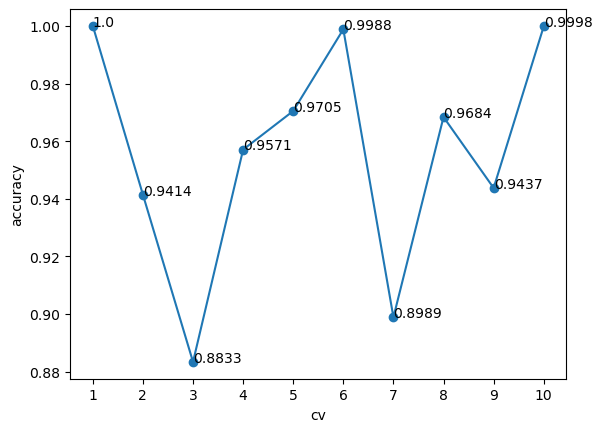

In [39]:
#Use random search to find the best parameters
knn = KNeighborsClassifier() 
random_search = RandomizedSearchCV(knn, param_distributions={'n_neighbors': range(1, 11), 'metric': ['euclidean', 'manhattan']}, n_iter=20, cv=None)
random_search.fit(x_train_pca, y_train)

# Get the best parameters found by RandomizedSearchCV and create a new KNN classifier
best_params = random_search.best_params_
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], metric=best_params['metric'])  
best_knn.fit(x_train_pca, y_train)  
predictions = best_knn.predict(x_test_pca)
accuracy = sum(predictions == y_test) / len(y_test)  

# Plot a line graph showing the accuracy for different values of the parameter cv
print("Accuracy:", accuracy)
plt.plot(range(1,11),accuracy,'-o')
plt.xticks(np.arange(1, 11, 1))
plt.xlabel('cv')
plt.ylabel('accuracy')
for i, acc in enumerate(accuracy):  
    plt.text(i+1, acc, round(acc,4))
plt.show

[0.14694592300906772, 0.24005658506774252, 0.13151687905582998, 0.18511893012513614, 0.12747589781677982, 0.16741852095955956, 0.1279101999212673, 0.15923632462476434, 0.12934641681805448, 0.1548945079920554, 0.13088214269384613, 0.15198884134434698, 0.13285266136056195, 0.1527571113289461, 0.13478969067796132, 0.15225593089350675, 0.13689365375157647, 0.15382581523648287, 0.13829635899511883, 0.15312459086230334, 0.13946525215149275, 0.15359204775717272, 0.14173624934900408, 0.15479441911089853, 0.14323918844924122, 0.1554290216493086, 0.14444145943528675, 0.1543603846535586, 0.14624482130649719, 0.15669810405451956]


<function matplotlib.pyplot.show(close=None, block=None)>

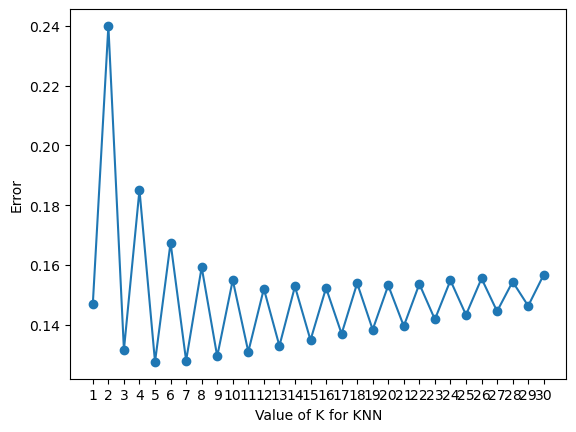

In [40]:
k_range = range(1,31)
k_error = []
for k in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Calculate accuracy score using cross-validation
    scores = cross_val_score(knn,x_train_pca,y_train,cv=10,scoring='accuracy')
    # Get error rate for observation
    k_error.append(1 - scores.mean())
print(k_error)
plt.plot(k_range,k_error,'-o')
plt.xticks(np.arange(1, 31, 1))
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.show

Optimal value of k: 5


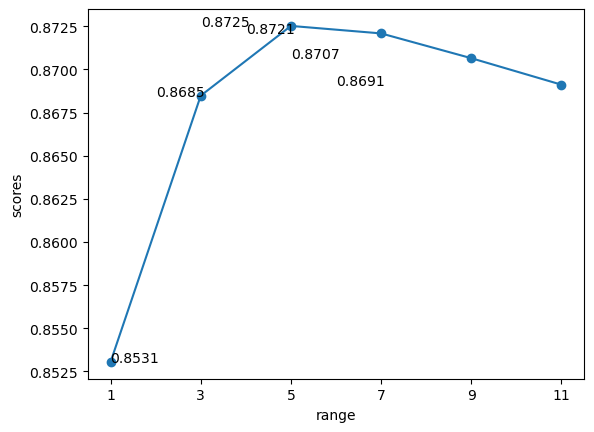

In [42]:
# Define a list of odd numbers based on the previous validation to narrow down the range
k_values = list(range(1,12,2))
cv_scores = []

# Calculate accuracy score using 10-fold cross-validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_pca, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best k value
optimal_k_index = cv_scores.index(max(cv_scores))
optimal_k = k_values[optimal_k_index]
print("Optimal value of k:", optimal_k)
plt.plot(k_values,cv_scores,'-o')
plt.xticks(np.arange(1, 12, 2))
plt.xlabel('range')
plt.ylabel('scores')
for i, sco in enumerate(cv_scores):  
    plt.text(i+1, sco, round(sco,4))

In [43]:
#Substituting the optimal value
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_train_pca, y_train)
yt_pred = knn.predict(x_test_pca)
accuracy_M3 = accuracy_score(y_test, yt_pred)
print("Accuracy:", accuracy_M3)

Accuracy: 0.7320969375827944


In [44]:
#Confusion matrix
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_train_pca, y_train)
yt_pred = knn.predict(x_test_pca)
cm = confusion_matrix(y_test.argmax(axis=1), yt_pred.argmax(axis=1))
print("Confusion_matrix:")
print(cm)
print("\nCLASSIFICATION REPORT:\n ",classification_report(y_test, yt_pred))

Confusion_matrix:
[[   0    0    0    0    0    0    0    0    0    0]
 [ 176 1492   46   45    0    0   26  146   58    0]
 [  59    4 5017    1   46    0  464    0    4    0]
 [  65   13   10  235    0    0    0    4  303    0]
 [  21   13  326    0  557    0    2    0    0    0]
 [   3    3    7    0    0  389    0    0    1    0]
 [ 123   10  697    5    0    0  564    1  109    0]
 [  31  267    0    2    0    0    1   90    8    0]
 [ 109   45   14  136    0    0   11    4  786    0]
 [   0   19    0    0    0    0    0    0    0  265]]

CLASSIFICATION REPORT:
                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.80      0.75      0.77      1989
           2       0.82      0.90      0.86      5595
           3       0.55      0.37      0.45       630
           4       0.92      0.61      0.73       919
           5       1.00      0.97      0.98       403
           6       0.53      0.37      0.44   

C:\Users\86151\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\86151\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\86151\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3.Comprehensive analysis

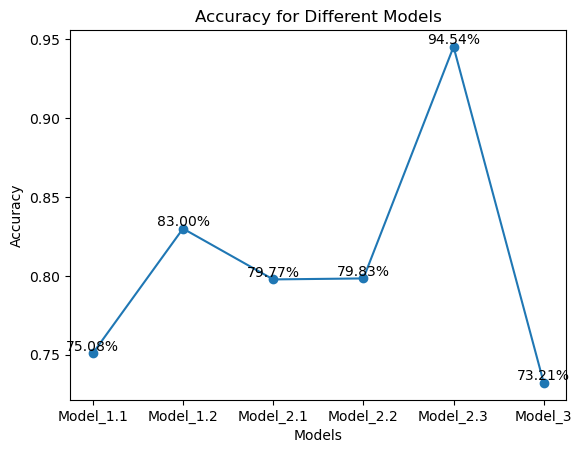

In [45]:
#To summarize the accuracy of all models and create a line plot
acc = [accuracy_M11, accuracy_M12, accuracy_M21, accuracy_M22, accuracy_M23, accuracy_M3]
models = ['Model_1.1', 'Model_1.2', 'Model_2.1', 'Model_2.2', 'Model_2.3', 'Model_3']

plt.plot(models, acc, 'o-')
plt.title('Accuracy for Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
for i, acc in enumerate(acc):
    plt.text(models[i], acc, f'{acc:.2%}', ha='center', va='bottom')
plt.show()